In [3]:
from gurobipy import *
from gurobipy import tupledict

import numpy as np
import pandas as pd
import scipy
import timeit
import time
import random
import math

import pdb

from pandas import ExcelWriter

from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def intersection(lst1, lst2):
    return [value for value in lst1 if value in lst2]

def diff_set(lst1, lst2):
    return [value for value in lst1 if value not in lst2]

def state(a):
    M=20
    States = np.linspace(0,230.5/4, M+1)
    return [l for l in range(M) if States[l]<=a<States[l+1]]

In [7]:
def simulate_dynamic(low_Td=2, max_Td=10, eta_v = 0.9, eta_DC_v= 0.9, Trans_P=100, low_dl =0.75, high_dl=0.95, S=1, 
                             gamma_v=1, delta=0.05, delta1=1, delta3=1, NumberOfDays=1,Day_of_Month=15, plan_int = 1, p=1, 
                             NumberOfVehicles=100, delta2=0, MipGap=2e-2, timelim=200, intervalTime=0.25):

    low_Td = low_Td/intervalTime ## convert to delta t
    max_Td = max_Td/intervalTime
    N = NumberOfVehicles*NumberOfDays
    num_interval = int(1/intervalTime)     ### number of intervals in one hour
    T = int(NumberOfDays*24*num_interval)
    Onehour_interval = NumberOfDays*24
    plan_interval = NumberOfDays*24*plan_int

    ##Setting number
    global l

    ## Determine the vehicles in discharge mode vs only charge mode
    np.random.seed(101)
    array= np.arange(1,N+1)
    random.shuffle(array)
    V2G_EV= list(array[:int(len(array)*p)])
    G2V_EV = [i for i in range(1,N+1) if i not in V2G_EV]

    ##### General EV data
    #####
    df= pd.read_excel('OptimizationEV.xlsx', sheet_name= 'Opt100_2')
    EV_data= df[['EV', 'Ta', 'Td', 'BC', "IS", 'DL', 'pc', 'AR']].iloc[0:100]
    wind_data= df[['Price', 'Time','Time2', 'Wind prod']].iloc[0:96]

    wind_data.set_index('Time2', inplace=True)
    EV_data.set_index('EV', inplace=True)

    ######## EV arrivals
    ########
    trip_df = pd.read_csv('TripStartTime_TripReason.csv')
    trip_df2= trip_df.iloc[31:, :]
    trip_df2.columns = trip_df.iloc[30]
    trip_df2.reset_index(inplace=True)
    trip_df2[['Home', 'Work']] = trip_df2[['Home', 'Work']].astype('int32', inplace=True)

    prob_home= list(trip_df2.iloc[:-1]['Home']/trip_df2.iloc[-1]['Home'])
    prob_work =list(trip_df2.iloc[:-1]['Work']/trip_df2.iloc[-1]['Work'])

    np.random.seed(3)
    elems = range(1, NumberOfDays*24+1)
    probabilities = [(x+y)/(NumberOfDays*2) for x,y in zip(prob_home, prob_work)]*NumberOfDays
    trips = list(np.random.choice(elems, int(N), p=probabilities))

    np.random.seed(2)
    ######### Wind data
    #########
    df_results = pd.read_csv("results_power.csv")

    Apr_wind = df_results[df_results['Time stamp'].str.find('Apr '+ str(Day_of_Month)) != -1]
    May_wind = df_results[df_results['Time stamp'].str.find('May '+ str(Day_of_Month)) != -1]
    Jun_wind = df_results[df_results['Time stamp'].str.find('Jun '+ str(Day_of_Month)) != -1]
    Jul_wind = df_results[df_results['Time stamp'].str.find('Jul '+ str(Day_of_Month)) != -1]
    Aug_wind = df_results[df_results['Time stamp'].str.find('Aug '+ str(Day_of_Month)) != -1]

    Oct_wind = df_results[df_results['Time stamp'].str.find('Oct '+ str(Day_of_Month)) != -1]
    Dec_wind = df_results[df_results['Time stamp'].str.find('Dec '+ str(Day_of_Month)) != -1]
    Jan_wind = df_results[df_results['Time stamp'].str.find('Jan '+ str(Day_of_Month)) != -1]
    Feb_wind = df_results[df_results['Time stamp'].str.find('Feb '+ str(Day_of_Month)) != -1]
    Nov_wind = df_results[df_results['Time stamp'].str.find('Nov '+ str(Day_of_Month)) != -1]

    if NumberOfDays>1:
        for i in range(1,NumberOfDays):
            Apr_wind = Apr_wind.append(df_results[df_results['Time stamp'].str.find('Apr ' +str(Day_of_Month+i)) != -1])
            May_wind = May_wind.append(df_results[df_results['Time stamp'].str.find('May ' +str(Day_of_Month+i)) != -1])
            Jun_wind = Jun_wind.append(df_results[df_results['Time stamp'].str.find('Jun ' +str(Day_of_Month+i)) != -1])
            Jul_wind = Jul_wind.append(df_results[df_results['Time stamp'].str.find('Jul ' +str(Day_of_Month+i)) != -1])
            Aug_wind = Aug_wind.append(df_results[df_results['Time stamp'].str.find('Aug ' +str(Day_of_Month+i)) != -1])

            Oct_wind = Oct_wind.append(df_results[df_results['Time stamp'].str.find('Oct ' +str(Day_of_Month+i)) != -1])
            Dec_wind = Dec_wind.append(df_results[df_results['Time stamp'].str.find('Dec ' +str(Day_of_Month+i)) != -1])
            Jan_wind = Jan_wind.append(df_results[df_results['Time stamp'].str.find('Jan ' +str(Day_of_Month+i)) != -1])
            Feb_wind = Feb_wind.append(df_results[df_results['Time stamp'].str.find('Feb ' +str(Day_of_Month+i)) != -1])
            Nov_wind = Nov_wind.append(df_results[df_results['Time stamp'].str.find('Nov ' +str(Day_of_Month+i)) != -1])

    Summer_wind = [Apr_wind, May_wind, Jun_wind, Jul_wind, Aug_wind]
    Winter_wind = [Oct_wind, Dec_wind, Jan_wind, Feb_wind, Nov_wind]

    wind_summer = []
    for month in Summer_wind:
        month= [month.iloc[k//num_interval]['System power generated | (kW)']/num_interval for k in range(T)] 
        month = pd.Series(month, index= range(T))
        wind_summer.append(month)

    wind_winter = []
    for month in Winter_wind:
        month= [month.iloc[k//num_interval]['System power generated | (kW)']/num_interval for k in range(T)] 
        month = pd.Series(month, index= range(T))
        wind_winter.append(month)

    M=20
    States = np.linspace(0,230.5/4, M+1)
    value = [(i+j)/2 for i, j in zip(States[:M], States[1:M+1])]
    transition = np.zeros((M, M))
    transition_p = np.zeros((M, M))

    for i in range(M):
        for j in range(M):
            transition[i,j] = sum([((States[i]<=k/4<States[i+1]) and (States[j]<=l/4<States[j+1])) 
                               for k,l in zip(df_results['System power generated | (kW)'].iloc[:-1]
                                              ,df_results['System power generated | (kW)'].iloc[1:])])
    for i in range(M):
        for j in range(M):
            transition_p[i,j] = transition[i,j]/sum(transition[i,:])

    transition_prob ={}
    for hours in range(1,11):
        transition_prob[hours] = np.linalg.matrix_power(transition_p, hours)

    ####### Price Data 
    #######
    Price_df = pd.DataFrame(np.zeros((Onehour_interval,1)), index = range(Onehour_interval))
    Summer = ['Apr', 'May', 'Jun', 'Jul', 'Aug']
    Winter = ['Oct', 'Nov', 'Dec','Jan', 'Feb']

    for i in Summer:
        name_df = pd.read_csv('LMPdata/' + i+'_LMP.csv')
        name_df = name_df[name_df['XML_DATA_ITEM'] == 'LMP_PRC']
        name_df = name_df.sort_values('INTERVALSTARTTIME_GMT')[['INTERVALSTARTTIME_GMT', 'MW']]
        name_df.reset_index(inplace=True)
        Price_df[i+'LMP'] = name_df.iloc[:Onehour_interval]['MW']

    for i in Winter:
        name_df = pd.read_csv('LMPdata/' + i+'_LMP.csv')
        name_df = name_df[name_df['XML_DATA_ITEM'] == 'LMP_PRC']
        name_df = name_df.sort_values('INTERVALSTARTTIME_GMT')[['INTERVALSTARTTIME_GMT', 'MW']]
        name_df.reset_index(inplace=True)
        Price_df[i+'LMP'] = name_df.iloc[:Onehour_interval]['MW']

    price_summer = []
    for month in Summer:
        price = [max(0,Price_df.iloc[k//num_interval][month+'LMP'])/10 for k in range(T)] #wind data for 96 time slots (every 15 minutes)
        price = pd.Series(price, index= range(T))
        price_summer.append(price)

    price_winter = []
    for month in Winter:
        price = [max(0,Price_df.iloc[k//num_interval][month+'LMP'])/10 for k in range(T)] #wind data for 96 time slots (every 15 minutes)
        price = pd.Series(price, index= range(T))
        price_winter.append(price)

    ### Degradation params
    alpha= 1e-1
    beta = 5e-2

    excedding_consumption, wind_curtailment, degradation_c, objective = [], [], [], []

    Total_consumption, Charge_cost, total_wind, Charge_time, Num_variables, Num_Constraints, RunTime = [],[], [], [],[], [],[]

    charge_load, discharge_load, Cost_tot= [],[],[]
    violation=[]

    Month = ''
    dataset=[]

    park_time = (low_Td +max_Td)/2 -2

    #Simulate S times
    for k in range(S):
        FinalState = np.zeros((N,1))
        if k<5:
            Month = Summer[k%5]
            w = wind_summer[k%5]
            price = price_summer[k%5]
        else:
            Month = Winter[k%5]
            w = wind_winter[k%5]
            price = price_winter[k%5]

        elements = range(1, NumberOfDays*24+1)
        probabilities = [x/NumberOfDays for x in prob_home]*NumberOfDays
        home_trip_time = np.random.choice(elements, int(N/2), p=probabilities)

        probabilities = [x/NumberOfDays for x in prob_work]*NumberOfDays
        work_trip_time = np.random.choice(elements, int(N/2), p=probabilities)

        Ta = list(home_trip_time*num_interval-np.random.randint(1,num_interval,int(N/2)))
        Ta += list(work_trip_time*num_interval-np.random.randint(1,num_interval,int(N/2)))
        Td = list(Ta + np.random.randint(low_Td,max_Td+1, N))
        Td= map(lambda x: min(x,T), Td)
        Ta= pd.Series(Ta, index=range(1,N+1))
        Td= pd.Series(Td, index=range(1,N+1))

        E={}
        for i in range(1,Onehour_interval+1):
            lst= list(Ta[np.ceil(Ta/num_interval) == i].index)
            E['E' + str(i)] = list(map(int, lst))

        ## The set of EVs are fixed

        car = np.random.randint(1,101, N)
        BC = EV_data['BC'][list(car)]
        BC.index = range(1,N+1)
        AR = EV_data['AR'][list(car)]
        pc= EV_data['pc'][list(car)]
        AR.index = range(1,N+1)
        pc.index = range(1,N+1)

        chargepow = np.minimum(AR.values, pc.values)
        chargepow= pd.Series(chargepow, index=range(1,N+1))
        eta = pd.Series(eta_v, index=range(1,N+1))
        eta_DC = pd.Series(eta_DC_v, index=range(1,N+1))

        Degradation_cost1 = pd.Series(0.0, index= range(1,N+1))
        Degradation_cost2 = pd.Series(0.0, index= range(1,N+1))
        revenue = pd.Series(0.0, index= range(1,N+1))
        FinalState = pd.Series(np.zeros((N)), index = range(1,N+1))
        Xch = pd.Series(0.0, index= range(1,N+1))
        Xdch = pd.Series(0.0, index= range(1,N+1))

        cons_w = pd.Series(0.0, index= range(1,N+1))
        cons_z = pd.Series(0.0, index= range(1,N+1))
        cons_DC = pd.Series(0.0, index= range(1,N+1))
        cost = pd.Series(0.0, index= range(1,N+1))
        wind_ev = pd.Series(0.0, index= range(1,N+1))

        #generate using uniform :D
        IS = pd.Series(np.zeros((N)),index = range(1,N+1))
        DL = pd.Series(np.zeros((N)), index= range(1,N+1))
        minSOC = pd.Series(np.zeros((N)), index= range(1,N+1))

        for i in range(1,N+1):
            IS[i] = np.random.uniform(0.1, (low_dl-0.1)*BC[i])
            DL[i] = np.random.uniform(low_dl*BC[i], high_dl*BC[i])
            minSOC[i] = 5
    
        for i in range(1,N+1):
            if Td[i] == T:
                DL[i] = DL[i] * (T-Td[i]) / (max_Td - low_Td)

        ISSS = IS.copy()
        mean_IS= IS.mean()

        for i in range(1,N+1):
            BC[i] = max(BC[i], chargepow[i]/num_interval+DL[i])

        EE ={}
        for t in range(T):
            EE[t] = [i for i in range(1, N+1) if t in range(Ta[i], Td[i])]

        consumption =0
        m =[]

        D = pd.Series(0, index=range(0,T), dtype= 'float32')
        curr = pd.Series(0, index=range(0,T), dtype= 'float32')
        charging_load = pd.Series(0, index=range(0,T), dtype= 'float32')
        discharging_load = pd.Series(0, index=range(0,T), dtype= 'float32')

        Consumption_wind, Consumption_DC, Consumption_z = 0 ,0 ,0

        X= tupledict()
        Y1= tupledict()
        Y2= tupledict()
        SOC= tupledict()
        z= tupledict()
        c= tupledict()
        SOC_D= tupledict()

        XX= tupledict()

        numVar=0
        numCon = 0
        runTime = 0
        obj =0 

        rev=0

        Num_Charge_restarts = pd.Series(np.zeros((N)), index= range(1,N+1))
        Num_DisCharge_restarts = pd.Series(np.zeros((N)), index= range(1,N+1))

        #################################### DYNAMIC 
        for j in range(1,Onehour_interval):

            m.append(Model('Dynamic_Time' + str(j) + ' Scenario' + str(k)))
            print('\n\nSolving problem at TIME {}_{}'.format(k, j))
            period=j*num_interval    

            ### wind forecast
            w_fc = w.copy()

            if j==1:
                Last_charge = pd.Series([int(0) for i in E['E'+str(j)]], index= [i for i in E['E'+str(j)]])
                Last_charge_XX = pd.Series([int(0) for i in intersection(E['E'+str(j)],V2G_EV)], 
                                           index= [i for i in intersection(E['E'+str(j)],V2G_EV)])
                V2G_EVV = intersection(E['E'+str(j)], V2G_EV)
                G2V_EVV = intersection(E['E'+str(j)], G2V_EV)
            if j>1:
                for i in E['E'+str(j-1)]:
                    if Td[i] > period:
                        E['E'+str(j)] += [i]
                        IS[i] = SOC[j-2][i,period].x
                    else:
                        continue

                V2G_EVV = intersection(E['E'+str(j)], V2G_EV)
                G2V_EVV = intersection(E['E'+str(j)], G2V_EV)
                Last_charge = pd.Series([round(X[j-2][i,period-1].x) for i in intersection(E['E'+str(j)], E['E'+str(j-1)])]
                                        +[int(0) for i in diff_set(E['E'+str(j)], E['E'+str(j-1)])],
                                        index= [i for i in intersection(E['E'+str(j)], E['E'+str(j-1)])] 
                                        +[i for i in diff_set(E['E'+str(j)], E['E'+str(j-1)])])
                Last_charge_XX = pd.Series([round(XX[j-2][i,period-1].x) for i in intersection(V2G_EVV, E['E'+str(j-1)])]
                                           +[int(0) for i in diff_set(V2G_EVV, E['E'+str(j-1)])],
                                            index= [i for i in intersection(V2G_EVV, E['E'+str(j-1)])] 
                                           +[i for i in diff_set(V2G_EVV, E['E'+str(j-1)])])

            Immediate_chargeP = pd.Series(np.zeros((N)), index= range(1,N+1), dtype='int')  ## number of charging periods required

            for i in E['E'+str(j)]:
                if minSOC[i]> IS[i]:
    #                 print('LOOK HERE', i, minSOC[i], IS[i])
                    timetoreachminLev= int(math.ceil((minSOC[i]+0.1-IS[i])*num_interval/(eta[i]*chargepow[i])))
                    Immediate_chargeP[i]= min(Td[i]-period, timetoreachminLev)

            B = [i for i in E['E'+str(j)] if IS[i] < minSOC[i]]
            AA = [i for i in E['E'+str(j)] if IS[i] >= minSOC[i]]
            ## if there is no vehicle to plan go to the next planning time
            if E['E' +str(j)] == []:
                continue

            max_tau = max([Td[i] for i in E['E' +str(j)]])


            ########################################################## Calculate wind forecast
            real_w = w[period]
            for hours in range(1,max_tau//num_interval - j):
                w_f = sum(np.multiply(transition_prob[hours][state(real_w)[0], :],value))
                for t in range(period+hours*num_interval, period+(hours+1)*num_interval):
                    w_fc[t]= w_f

            DF ={} ## dummy future arrivals
            TAD =[]
            TDD =[]
            ISD, DLD, BCD, CPD = [],[],[],[]

            for per in range(j+1, ((max_tau-1)//num_interval)+1):
                DF['E'+str(j)+'_' + str(per)]= sum([1 for i in trips if i==per])
                for v in range(DF['E'+str(j)+'_' + str(per)]):
                    TAD.append(per*num_interval)
                    TDD.append(int(min(per*num_interval +park_time, T)))
                    ISD.append(mean_IS)
                    DLD.append(DL.mean())
                    BCD.append(BC.mean())
                    CPD.append(chargepow.mean())

    #         print('LOOK HERE ', DL.mean(), mean_IS)
    #         print('park time ', park_time)
            set_DF = range(0,len(TAD))

            EE_D ={}
            n_arrival_t ={}
            D_DA ={}
            for t in range(period, max_tau):
                EE_D[t] = [i for i in set_DF if t in range(TAD[i], TDD[i])]
                n_arrival_t[t] = len([i for i in set_DF if t in range(TAD[i], TDD[i])])
                D_DA[t] = ((DL.mean()-mean_IS)/park_time)*n_arrival_t[t]

    #         print('Average arrival ', n_arrival_t)
    #         print('average Demand is ', D_DA)

            #Creating a model instance

            X[j-1] = m[j-1].addVars(((i,t) for i in E['E'+str(j)] for t in range(period, Td[i])),ub=1, vtype= GRB.CONTINUOUS, name= 'X_' +str(j))

            XX[j-1] = m[j-1].addVars(((i,t) for i in V2G_EVV for t in range (period, Td[i])),ub=1, vtype= GRB.CONTINUOUS, name= 'XX'+str(j))

            Y1[j-1] = m[j-1].addVars(((i,t) for i in V2G_EVV for t in range (period, Td[i])), vtype= GRB.BINARY, name= 'Y')
            Y2[j-1] = m[j-1].addVars(((i,t) for i in V2G_EVV for t in range(period, Td[i])), vtype= GRB.BINARY, name= 'YY')

            SOC[j-1] = m[j-1].addVars(((i,t) for i in E['E'+str(j)] for t in range(period,Td[i]+1)), vtype= GRB.CONTINUOUS, name= 'SOC')

            z[j-1] = m[j-1].addVars((t for t in range(period, max_tau)), vtype= GRB.CONTINUOUS, lb=0, name= 'z')

            c[j-1] = m[j-1].addVars((t for t in range(period, max_tau)), vtype = GRB.CONTINUOUS, lb= 0, name='Curtail')

            m[j-1].update()

            #Obj Function

            ### I think I need to change this later
            m[j-1].setObjective((sum(delta1*z[j-1][t]*price[t] + delta*price[t]*c[j-1][t]  for t in range(period,max_tau))
                                + delta3*
                                       (quicksum(alpha*((eta[i]*chargepow[i]/num_interval)**2)*
                                                 (X[j-1][i,t] - X[j-1][i,t-1])*(X[j-1][i,t] -X[j-1][i,t-1])
                                                 for i in E['E'+str(j)] for t in range(period+1, Td[i]))
                                       + quicksum(alpha*((eta[i]*chargepow[i]/num_interval)**2)*
                                                 (X[j-1][i,period] - Last_charge[i])*(X[j-1][i,period]-Last_charge[i])
                                                 for i in E['E'+str(j)])
                                       + quicksum(beta*((eta[i]*chargepow[i]/num_interval)**2)*
                                                  (X[j-1][i,t]*X[j-1][i,t])
                                                 for i in E['E'+str(j)] for t in range(period, Td[i]))
                                       + quicksum(alpha*(((chargepow[i]/num_interval)/eta_DC[i])*(XX[j-1][i,t] - XX[j-1][i,t-1]))*
                                             (((chargepow[i]/num_interval)/eta_DC[i])*(XX[j-1][i,t] - XX[j-1][i,t-1]))
                                             for i in V2G_EVV for t in range(period+1, Td[i]))
                                       + quicksum(alpha*(((chargepow[i]/num_interval)/eta_DC[i])*(XX[j-1][i,period] - Last_charge_XX[i]))*
                                             (((chargepow[i]/num_interval)/eta_DC[i])*(XX[j-1][i,period] - Last_charge_XX[i]))
                                             for i in V2G_EVV)
                                       + quicksum(beta*(((chargepow[i]/num_interval)/eta_DC[i])**2)*
                                                  (XX[j-1][i,t]*XX[j-1][i,t])
                                                 for i in V2G_EVV for t in range(period, Td[i]))
                                       )),GRB.MINIMIZE)


            #Initial State of Battery
            m[j-1].addConstrs((SOC[j-1][i,period] == IS[i] for i in E['E'+str(j)]), name='InitialState')

            # State of Charge
            m[j-1].addConstrs((SOC[j-1][i,t]==SOC[j-1][i,t-1] + X[j-1][i,t-1]*eta[i]*chargepow[i]/num_interval 
                               for i in G2V_EVV for t in range(period+1, Td[i]+1)), name= 'StateofChargeG2V')
            m[j-1].addConstrs((SOC[j-1][i,t]==SOC[j-1][i,t-1] + (X[j-1][i,t-1]*eta[i]*chargepow[i] - (XX[j-1][i,t-1]/eta_DC[i])*chargepow[i])/num_interval 
                               for i in V2G_EVV for t in range(period+1, Td[i]+1)), name= 'StateofChargeV2G')


            # Excessive Consumption
            m[j-1].addConstrs(z[j-1][t] >= sum((X[j-1][i,t]-XX[j-1][i,t])*chargepow[i]/num_interval for i in intersection(V2G_EVV, EE[t]))
                                      + sum((X[j-1][i,t])*chargepow[i]/num_interval for i in intersection(G2V_EVV, EE[t]))
                                      + D_DA[t]
                                      - w_fc[t] for t in range(period,max_tau))

            # Transmission limit
            m[j-1].addConstrs((z[j-1][t] <= Trans_P for t in range(period,max_tau)), name ='transmission')

            # either Charge or discharge or do nothing
            m[j-1].addConstrs(X[j-1][i,t] <= 2*(1-Y1[j-1][i,t]) for i in V2G_EVV for t in range(period, Td[i]))
            m[j-1].addConstrs(XX[j-1][i,t] <= 2*(1-Y2[j-1][i,t]) for i in V2G_EVV for t in range(period, Td[i]))
            m[j-1].addConstrs(0.99<=Y1[j-1][i,t]+Y2[j-1][i,t]<=1.01 for i in V2G_EVV for t in range(period, Td[i]))

            #Full Charge when we don't reach the desired level during plugin
            m[j-1].addConstrs((X[j-1][i,t]>=1 for i in E['E'+str(j)] for t in range(period, Td[i]) 
                               if IS[i]+chargepow[i]*eta[i]*(Td[i] - period)/num_interval < DL[i]), name='full charge')

            #Final state of charge should be more than desired level
            m[j-1].addConstrs(SOC[j-1][i,Td[i]] >= DL[i] for i in E['E'+str(j)] if 
                              IS[i]+ chargepow[i]*eta[i]*(Td[i] - period)/num_interval >= DL[i])

            #BatteryCapacity
            m[j-1].addConstrs((SOC[j-1][i,t] <= BC[i] for i in E['E'+str(j)] for t in range(period, Td[i]+1)), name= 'Battery Capacity')


            # Min level of Charge
            m[j-1].addConstrs((SOC[j-1][i,t] >= minSOC[i]+0.1 for i in AA for t in range(period+1,Td[i]+1)), name= 'MinStateofCharge')

            # Min level of Charge2
            m[j-1].addConstrs((X[j-1][i,t]>=1 for i in B for t in range(period, period+Immediate_chargeP[i])),name= 'MinStateofCharge2')

            # Min level of Charge3
            m[j-1].addConstrs((SOC[j-1][i,t] >= minSOC[i]-0.1 for i in B for t in range(period+Immediate_chargeP[i], Td[i]+1) 
                             if period+Immediate_chargeP[i] != Td[i]), name= 'MinStateofCharge3')


            #curtailment
            m[j-1].addConstrs(c[j-1][t] >= w_fc[t]- sum((X[j-1][i,t]-XX[j-1][i,t])*chargepow[i]/num_interval for i in intersection(V2G_EVV, EE[t]))
                                      - sum((X[j-1][i,t])*chargepow[i]/num_interval for i in intersection(G2V_EVV, EE[t]))
                                      - D_DA[t]
                                      for t in range(period,max_tau))

            m[j-1].update()

            print('NumVar and NumConstr = {}, {}'.format(m[j-1].NumVars, m[j-1].NumConstrs))

            m[j-1].params.OutputFlag = 0
            m[j-1].params.MIPGap = MipGap
            m[j-1].params.TimeLimit = timelim
            m[j-1].optimize()

            status = m[j-1].status

            #Loop until we reduce to a model that can be solved
            if status == GRB.Status.INFEASIBLE:
                m[j-1].computeIIS()
                print('\nThe following constraint cannot be satisfied:')
                for c in m[j-1].getConstrs():
                    if c.IISConstr:
                        print('%s' % c.constrName)
                print('')

            ## lets model the consumption for each EV:
            for t in range(period,(j+1)*num_interval):
                avail_w =  w[t]
                avail_DC = sum(XX[j-1][i,t].x*chargepow[i]/num_interval for i in intersection(EE[t], V2G_EVV))
                EVV = [(i,SOC[j-1][i,Td[i]].x - SOC[j-1][i,t].x) for i in intersection(E['E'+str(j)],EE[t]) if X[j-1][i,t].x>0]
                EVV.sort(key=lambda x: x[1], reverse = True) ##Set of charging vehicles, order the vehicles in ascending order of energy they require
                if len(EVV)==0:
                    continue
                for (ev, _) in EVV:
                    if avail_DC >= X[j-1][ev,t].x*chargepow[ev]/num_interval:
                        avail_DC -= X[j-1][ev,t].x*chargepow[ev]/num_interval
                        cons_DC[ev] += X[j-1][ev,t].x*chargepow[ev]/num_interval
                        Consumption_DC += X[j-1][ev,t].x*chargepow[ev]/num_interval
                        cost[ev] += 0.9*price[t]*(X[j-1][ev,t].x*chargepow[ev]/num_interval)
                        rev += 0.9*price[t]*(X[j-1][ev,t].x*chargepow[ev]/num_interval)
                    elif avail_DC< X[j-1][ev,t].x*chargepow[ev]/num_interval:
                        cons_DC[ev] += avail_DC
                        Consumption_DC += avail_DC
                        cost[ev] += 0.9*price[t]*avail_DC
                        rev += 0.9*price[t]*avail_DC
                        charge_required = X[j-1][ev,t].x*chargepow[ev]/num_interval-avail_DC
                        avail_DC = 0
                        if avail_w >= charge_required:
                            avail_w -= charge_required
                            cons_w[ev] += charge_required
                            Consumption_wind += charge_required
                            #cost[ev] += 0*price[t]*(charge_required)
                        elif avail_w < charge_required:
                            cons_w[ev] += avail_w
                            cons_z[ev] += charge_required - avail_w
                            Consumption_wind += avail_w
                            Consumption_z += charge_required - avail_w
                            #cost[ev] += 0*price[t]*(avail_w)
                            cost[ev] += price[t]*(charge_required - avail_w)
                            avail_w = 0


            for i in V2G_EVV:
                v= min(Td[i], (j+1)*num_interval)
                Degradation_cost1[i] += sum(alpha*((eta[i]*chargepow[i]/num_interval)**2)*((X[j-1][i,t].x - X[j-1][i,t-1].x)**2) 
                                            for t in range(period+1, v))
                Degradation_cost1[i] += sum(alpha*(((chargepow[i]/num_interval)/eta_DC[i])**2)*((XX[j-1][i,t].x - XX[j-1][i,t-1].x)**2) 
                                            for t in range(period+1, v))
                Degradation_cost1[i] += alpha*((eta[i]*chargepow[i]/num_interval)**2)*((X[j-1][i,period].x-Last_charge[i])**2)
                Degradation_cost1[i] += alpha*(((chargepow[i]/num_interval)/eta_DC[i])**2)*((XX[j-1][i,period].x-Last_charge_XX[i])**2)
                Degradation_cost2[i] += sum(beta*((eta[i]*chargepow[i]/num_interval)**2)*(X[j-1][i,t].x**2) for t in range(period, v))
                Degradation_cost2[i] += sum(beta*(((chargepow[i]/num_interval)/eta_DC[i])**2)*(XX[j-1][i,t].x**2) for t in range(period, v))
                Xch[i] += sum(X[j-1][i,t].x *chargepow[i]/num_interval for t in range(period, v))
                Xdch[i] += sum(XX[j-1][i,t].x *chargepow[i]/num_interval for t in range(period, v))
                revenue[i] += sum(price[t]*XX[j-1][i,t].x for t in range(period, v))

                for t in range(period, v):
                    D[t] += ((X[j-1][i,t].x-XX[j-1][i,t].x)*chargepow[i]/num_interval)
                    charging_load[t] += (X[j-1][i,t].x*chargepow[i]/num_interval)
                    discharging_load[t] += (XX[j-1][i,t].x*chargepow[i]/num_interval)  
                if Td[i] <= (j+1)*num_interval:  ### if the vehicle leaves before the next planning time
                    FinalState[i] = SOC[j-1][i,Td[i]].x

            for i in G2V_EVV:
                v= min(Td[i], (j+1)*num_interval)
                Degradation_cost1[i] += sum(alpha*((eta[i]*chargepow[i]/num_interval)**2)*((X[j-1][i,t].x - X[j-1][i,t-1].x)**2) 
                                            for t in range(period+1, v))
                Degradation_cost1[i] += alpha*((eta[i]*chargepow[i]/num_interval)**2)*((X[j-1][i,period].x-Last_charge[i])**2)
                Degradation_cost2[i] += sum(beta*((eta[i]*chargepow[i]/num_interval)**2)*(X[j-1][i,t].x**2) for t in range(period, v))
                Xch[i] += sum(X[j-1][i,t].x *chargepow[i]/num_interval for t in range(period, v))
                for t in range(period, v):
                    D[t] += (X[j-1][i,t].x *chargepow[i]/num_interval)
                    charging_load[t] += (X[j-1][i,t].x*chargepow[i]/num_interval) 
                if Td[i] <= (j+1)*num_interval:  ### if the vehicle leaves before the next planning time
                    FinalState[i] = SOC[j-1][i,Td[i]].x

            numVar += m[j-1].NumVars
            numCon += m[j-1].NumConstrs
            runTime += m[j-1].Runtime
            obj += m[j-1].objVal


        n_violated=0
        for i in range(1,N+1):
            wind_ev[i] = sum(w[t] for t in range(Ta[i], Td[i]))
            if FinalState[i]<DL[i]-0.01:
                n_violated+=1

        total_cost = pd.Series(cost+Degradation_cost1+Degradation_cost2, index=range(1,N+1))

        violation.append(n_violated)

        ZZ= (D-w).apply(lambda x: max(x, 0))
        CC = (w-D).apply(lambda x: max(x, 0))


        plt.figure(figsize=(14,8))
        plt.plot(range(T), charging_load, label= 'Charging load')
        plt.plot(range(T), w, label= 'Wind energy generated')
        plt.plot(range(T), discharging_load, label= 'Discharging load')
        plt.legend(loc='best')
        plt.xticks(np.arange(0,T,16), labels=[int(x/num_interval) for x in list(np.arange(0,96,16))*NumberOfDays])
        plt.xlabel('Time of the day',fontsize= 15)
        plt.ylabel('Energy in kWh', fontsize= 15)

    #         print('\n\n\nTotal exceeding energy consumption is {} kWh \n'.format(ZZ.sum()))
    #         print('Total wind production is {} kWh\n'.format(w.sum()))
    #         print('Total curtailment is {} kWh\n'.format(CC.sum()))
    #         print('Total Consumption is {} kWh\n'.format(D.sum()))
    #         print('Total charging cost is {} USD'.format(charging_cost))

        charging_cost = sum(ZZ[t]*price[t] for t in range(T))

        print(Consumption_wind,Consumption_DC, Consumption_z)

        degradation_c.append(sum(Degradation_cost1+Degradation_cost2))
        total_wind.append(w.sum())
        excedding_consumption.append(ZZ.sum())
        wind_curtailment.append(sum(CC)) 
#         wind_curtailment.append(sum(curr)) 
        Total_consumption.append(D.sum())
        Charge_cost.append(charging_cost)
        Charge_time.append((Td-Ta).mean())
        Cost_tot.append(total_cost.sum()-rev)
        Num_variables.append(numVar)
        Num_Constraints.append(numCon)
        RunTime.append(runTime)
        objective.append(obj)
        charge_load.append(charging_load.sum())
        discharge_load.append(discharging_load.sum())

        dummy_df= pd.DataFrame(data=[BC, AR, pc, chargepow, ISSS, DL, Ta, Td, FinalState, Degradation_cost1, Degradation_cost2],
                               index=['BC', 'AR', 'pc','chargepow', 'IS', 'DL', 'Ta', 'Td','FinalState','DegCost1','DegCost2']).transpose()

        dummy_df['wind']=pd.Series(w.sum(), index= range(1,N+1))
        dummy_df['Charge load kWh'] =pd.Series([Xch[i] for i in range(1,N+1)], index= range(1,N+1))
        dummy_df['Total Discharge kWh'] = pd.Series([Xdch[i] for i in V2G_EV], index= V2G_EV)
        dummy_df['Charge Cost'] =pd.Series([cost[i] for i in range(1,N+1)], index= range(1,N+1))
        dummy_df['Wind Usage'] = pd.Series([cons_w[i] for i in range(1,N+1)], index= range(1,N+1))
        dummy_df['Consumption from discharge'] = pd.Series([cons_DC[i] for i in range(1,N+1)], index= range(1,N+1))
        dummy_df['Consumption from grid'] = pd.Series([cons_z[i] for i in range(1,N+1)], index= range(1,N+1))
        dummy_df['Degradation Cost'] = pd.Series([Degradation_cost1[i]+Degradation_cost2[i] for i in range(1,N+1)], index= range(1,N+1))
        dummy_df['wind during park'] = pd.Series([wind_ev[i] for i in range(1,N+1)], index= range(1,N+1))
        dummy_df['Revenue'] = pd.Series([revenue[i] for i in range(1,N+1)], index= range(1,N+1))
        dummy_df['Is in V2G'] = pd.Series([(i in V2G_EV) for i in range(1,N+1)], index= range(1,N+1))
        dataset.append(dummy_df)

    EV_dataset = pd.concat(dataset, axis=0)
    EV_dataset.reset_index(inplace=True)
    if l ==1:
        with ExcelWriter('EV_Dataset_Stochastic.xlsx') as writer:
            EV_dataset.to_excel(writer, sheet_name='setting {}'.format(l))
    else: 
        with ExcelWriter('EV_Dataset_Stochastic.xlsx',engine="openpyxl", mode='a') as writer:
            EV_dataset.to_excel(writer, sheet_name='setting {}'.format(l))

    print('THIS IS DYNAMIC CASE With future arrivals:')
    print('Simulation Parameters are: \n')
    print('min parking time {}\nmax parking time {}\nnumber of Scenarios {}'.format(low_Td, max_Td, S))
    print('Delta {}\nNumber of Days {}\nNumber of Vehicles {}\nMin desired level {}\nMax desired level {}'.format
          (delta, NumberOfDays, N, low_dl, high_dl))
    print('Delta2 {}\neta_c {}\neta_dc {}\nTrans_P {}\nProb of V2G is {}'.format
          (delta2, eta_v, eta_DC_v, Trans_P, p))
    print('Total wind production: ', total_wind)
    print('exceeding consumption: ', excedding_consumption)
    print('Wind curtailment: ', wind_curtailment)
    print('total consumption: ', Total_consumption)
    print('total charging cost: ', Charge_cost)
    print('total charge demand: ', charge_load)
    print('total discharge: ', discharge_load)
    print('Charge cost per kWh is: ', [x/y for x,y in zip(Charge_cost, Total_consumption)])
    print('degradation cost: ', degradation_c)
    print('total cost (charge cost + deg cost - revenue): ', Cost_tot)
    print('average charge time: ', Charge_time)
    print('Total run time is: ', RunTime)
    print('Total number of variables: ', Num_variables)
    print('Total number of Constraints: ', Num_Constraints)
    print('Total number of Violations: ', violation)
    print('objective is: ', objective)

C:\tools\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]




Solving problem at TIME 0_1


Solving problem at TIME 0_2


Solving problem at TIME 0_3


Solving problem at TIME 0_4


Solving problem at TIME 0_5
NumVar and NumConstr = 288, 372


Solving problem at TIME 0_6
NumVar and NumConstr = 750, 930


Solving problem at TIME 0_7
NumVar and NumConstr = 1682, 2082


Solving problem at TIME 0_8
NumVar and NumConstr = 2101, 2591


Solving problem at TIME 0_9
NumVar and NumConstr = 2849, 3503


Solving problem at TIME 0_10
NumVar and NumConstr = 2815, 3477


Solving problem at TIME 0_11
NumVar and NumConstr = 3144, 3916


Solving problem at TIME 0_12
NumVar and NumConstr = 3285, 4073


Solving problem at TIME 0_13
NumVar and NumConstr = 3787, 4683


Solving problem at TIME 0_14
NumVar and NumConstr = 4260, 5241


Solving problem at TIME 0_15
NumVar and NumConstr = 4248, 5216


Solving problem at TIME 0_16
NumVar and NumConstr = 4598, 5649


Solving problem at TIME 0_17
NumVar and NumConstr = 4122, 5068


Solving problem at TIME 0_18
NumVar and Nu

NumVar and NumConstr = 4295, 5255


Solving problem at TIME 0_130
NumVar and NumConstr = 4107, 5024


Solving problem at TIME 0_131
NumVar and NumConstr = 4231, 5204


Solving problem at TIME 0_132
NumVar and NumConstr = 3592, 4441


Solving problem at TIME 0_133
NumVar and NumConstr = 3915, 4824


Solving problem at TIME 0_134
NumVar and NumConstr = 4041, 4990


Solving problem at TIME 0_135
NumVar and NumConstr = 4154, 5120


Solving problem at TIME 0_136
NumVar and NumConstr = 4343, 5345


Solving problem at TIME 0_137
NumVar and NumConstr = 4150, 5115


Solving problem at TIME 0_138
NumVar and NumConstr = 4711, 5789


Solving problem at TIME 0_139
NumVar and NumConstr = 4557, 5597


Solving problem at TIME 0_140
NumVar and NumConstr = 4091, 5024


Solving problem at TIME 0_141
NumVar and NumConstr = 3888, 4775


Solving problem at TIME 0_142
NumVar and NumConstr = 3352, 4134


Solving problem at TIME 0_143
NumVar and NumConstr = 3078, 3794


Solving problem at TIME 0_144
NumVar and

NumVar and NumConstr = 5086, 6226


Solving problem at TIME 1_16
NumVar and NumConstr = 5128, 6284


Solving problem at TIME 1_17
NumVar and NumConstr = 4717, 5787


Solving problem at TIME 1_18
NumVar and NumConstr = 4442, 5452


Solving problem at TIME 1_19
NumVar and NumConstr = 4433, 5445


Solving problem at TIME 1_20
NumVar and NumConstr = 3702, 4569


Solving problem at TIME 1_21
NumVar and NumConstr = 4025, 4954


Solving problem at TIME 1_22
NumVar and NumConstr = 3352, 4126


Solving problem at TIME 1_23
NumVar and NumConstr = 2916, 3599


Solving problem at TIME 1_24
NumVar and NumConstr = 2572, 3177


Solving problem at TIME 1_25
NumVar and NumConstr = 1872, 2322


Solving problem at TIME 1_26
NumVar and NumConstr = 1288, 1608


Solving problem at TIME 1_27
NumVar and NumConstr = 847, 1062


Solving problem at TIME 1_28
NumVar and NumConstr = 769, 969


Solving problem at TIME 1_29
NumVar and NumConstr = 643, 810


Solving problem at TIME 1_30
NumVar and NumConstr = 728, 90

NumVar and NumConstr = 3772, 4667


Solving problem at TIME 1_142
NumVar and NumConstr = 3155, 3906


Solving problem at TIME 1_143
NumVar and NumConstr = 2597, 3215


Solving problem at TIME 1_144
NumVar and NumConstr = 2030, 2534


Solving problem at TIME 1_145
NumVar and NumConstr = 1463, 1836


Solving problem at TIME 1_146
NumVar and NumConstr = 1120, 1403


Solving problem at TIME 1_147
NumVar and NumConstr = 716, 908


Solving problem at TIME 1_148
NumVar and NumConstr = 436, 552


Solving problem at TIME 1_149
NumVar and NumConstr = 295, 375


Solving problem at TIME 1_150
NumVar and NumConstr = 733, 917


Solving problem at TIME 1_151
NumVar and NumConstr = 1804, 2232


Solving problem at TIME 1_152
NumVar and NumConstr = 3721, 4572


Solving problem at TIME 1_153
NumVar and NumConstr = 4740, 5800


Solving problem at TIME 1_154
NumVar and NumConstr = 4997, 6107


Solving problem at TIME 1_155
NumVar and NumConstr = 5348, 6536


Solving problem at TIME 1_156
NumVar and NumCons

Solving problem at TIME 2_30
NumVar and NumConstr = 861, 1072


Solving problem at TIME 2_31
NumVar and NumConstr = 1596, 1964


Solving problem at TIME 2_32
NumVar and NumConstr = 3215, 3923


Solving problem at TIME 2_33
NumVar and NumConstr = 3918, 4776


Solving problem at TIME 2_34
NumVar and NumConstr = 4073, 4965


Solving problem at TIME 2_35
NumVar and NumConstr = 4519, 5514


Solving problem at TIME 2_36
NumVar and NumConstr = 4932, 6021


Solving problem at TIME 2_37
NumVar and NumConstr = 5979, 7297


Solving problem at TIME 2_38
NumVar and NumConstr = 6804, 8304


Solving problem at TIME 2_39
NumVar and NumConstr = 7022, 8596


Solving problem at TIME 2_40
NumVar and NumConstr = 6463, 7944


Solving problem at TIME 2_41
NumVar and NumConstr = 6146, 7574


Solving problem at TIME 2_42
NumVar and NumConstr = 5864, 7240


Solving problem at TIME 2_43
NumVar and NumConstr = 5689, 7005


Solving problem at TIME 2_44
NumVar and NumConstr = 4746, 5847


Solving problem at TIME 2_

NumVar and NumConstr = 3321, 4086


Solving problem at TIME 2_157
NumVar and NumConstr = 3288, 4039


Solving problem at TIME 2_158
NumVar and NumConstr = 3198, 3928


Solving problem at TIME 2_159
NumVar and NumConstr = 4191, 5139


Solving problem at TIME 2_160
NumVar and NumConstr = 5408, 6638


Solving problem at TIME 2_161
NumVar and NumConstr = 5514, 6791


Solving problem at TIME 2_162
NumVar and NumConstr = 5315, 6538


Solving problem at TIME 2_163
NumVar and NumConstr = 4898, 6023


Solving problem at TIME 2_164
NumVar and NumConstr = 4462, 5508


Solving problem at TIME 2_165
NumVar and NumConstr = 4152, 5126


Solving problem at TIME 2_166
NumVar and NumConstr = 3454, 4260


Solving problem at TIME 2_167
NumVar and NumConstr = 2908, 3593


Solving problem at TIME 2_168
NumVar and NumConstr = 2326, 2872


Solving problem at TIME 2_169
NumVar and NumConstr = 1698, 2103


Solving problem at TIME 2_170
NumVar and NumConstr = 1449, 1797


Solving problem at TIME 2_171
NumVar and

Solving problem at TIME 3_44
NumVar and NumConstr = 3972, 4873


Solving problem at TIME 3_45
NumVar and NumConstr = 3891, 4772


Solving problem at TIME 3_46
NumVar and NumConstr = 3418, 4201


Solving problem at TIME 3_47
NumVar and NumConstr = 2862, 3519


Solving problem at TIME 3_48
NumVar and NumConstr = 2210, 2727


Solving problem at TIME 3_49
NumVar and NumConstr = 1666, 2073


Solving problem at TIME 3_50
NumVar and NumConstr = 1248, 1550


Solving problem at TIME 3_51
NumVar and NumConstr = 926, 1156


Solving problem at TIME 3_52
NumVar and NumConstr = 638, 806


Solving problem at TIME 3_53
NumVar and NumConstr = 395, 501


Solving problem at TIME 3_54
NumVar and NumConstr = 900, 1142


Solving problem at TIME 3_55
NumVar and NumConstr = 1305, 1617


Solving problem at TIME 3_56
NumVar and NumConstr = 2889, 3564


Solving problem at TIME 3_57
NumVar and NumConstr = 3595, 4414


Solving problem at TIME 3_58
NumVar and NumConstr = 3828, 4696


Solving problem at TIME 3_59
Nu



Solving problem at TIME 3_170
NumVar and NumConstr = 923, 1163


Solving problem at TIME 3_171
NumVar and NumConstr = 663, 838


Solving problem at TIME 3_172
NumVar and NumConstr = 474, 602


Solving problem at TIME 3_173
NumVar and NumConstr = 338, 429


Solving problem at TIME 3_174
NumVar and NumConstr = 760, 952


Solving problem at TIME 3_175
NumVar and NumConstr = 1712, 2121


Solving problem at TIME 3_176
NumVar and NumConstr = 2339, 2890


Solving problem at TIME 3_177
NumVar and NumConstr = 2433, 3012


Solving problem at TIME 3_178
NumVar and NumConstr = 3503, 4336


Solving problem at TIME 3_179
NumVar and NumConstr = 3803, 4683


Solving problem at TIME 3_180
NumVar and NumConstr = 4786, 5857


Solving problem at TIME 3_181
NumVar and NumConstr = 5183, 6382


Solving problem at TIME 3_182
NumVar and NumConstr = 4583, 5661


Solving problem at TIME 3_183
NumVar and NumConstr = 4771, 5884


Solving problem at TIME 3_184
NumVar and NumConstr = 4616, 5697


Solving problem a

NumVar and NumConstr = 4515, 5514


Solving problem at TIME 4_59
NumVar and NumConstr = 4478, 5525


Solving problem at TIME 4_60
NumVar and NumConstr = 4561, 5644


Solving problem at TIME 4_61
NumVar and NumConstr = 5355, 6634


Solving problem at TIME 4_62
NumVar and NumConstr = 4976, 6150


Solving problem at TIME 4_63
NumVar and NumConstr = 4498, 5543


Solving problem at TIME 4_64
NumVar and NumConstr = 4678, 5761


Solving problem at TIME 4_65
NumVar and NumConstr = 4466, 5492


Solving problem at TIME 4_66
NumVar and NumConstr = 3907, 4818


Solving problem at TIME 4_67
NumVar and NumConstr = 3230, 3984


Solving problem at TIME 4_68
NumVar and NumConstr = 3094, 3812


Solving problem at TIME 4_69
NumVar and NumConstr = 3105, 3821


Solving problem at TIME 4_70
NumVar and NumConstr = 2818, 3471


Solving problem at TIME 4_71
NumVar and NumConstr = 2178, 2688


Solving problem at TIME 4_72
NumVar and NumConstr = 1673, 2067


Solving problem at TIME 4_73
NumVar and NumConstr = 12

NumVar and NumConstr = 4570, 5596


Solving problem at TIME 4_185
NumVar and NumConstr = 5166, 6321


Solving problem at TIME 4_186
NumVar and NumConstr = 4977, 6116


Solving problem at TIME 4_187
NumVar and NumConstr = 4976, 6113


Solving problem at TIME 4_188
NumVar and NumConstr = 4723, 5817


Solving problem at TIME 4_189
NumVar and NumConstr = 3929, 4846


Solving problem at TIME 4_190
NumVar and NumConstr = 3089, 3815


Solving problem at TIME 4_191
NumVar and NumConstr = 2668, 3303


Solving problem at TIME 4_192
NumVar and NumConstr = 1964, 2429


Solving problem at TIME 4_193
NumVar and NumConstr = 1403, 1746


Solving problem at TIME 4_194
NumVar and NumConstr = 899, 1128


Solving problem at TIME 4_195
NumVar and NumConstr = 539, 681


Solving problem at TIME 4_196
NumVar and NumConstr = 301, 384


Solving problem at TIME 4_197
NumVar and NumConstr = 424, 546


Solving problem at TIME 4_198
NumVar and NumConstr = 585, 735


Solving problem at TIME 4_199
NumVar and NumConst

NumVar and NumConstr = 1471, 1852


Solving problem at TIME 5_73
NumVar and NumConstr = 1014, 1280


Solving problem at TIME 5_74
NumVar and NumConstr = 695, 880


Solving problem at TIME 5_75
NumVar and NumConstr = 477, 603


Solving problem at TIME 5_76
NumVar and NumConstr = 372, 471


Solving problem at TIME 5_77
NumVar and NumConstr = 529, 669


Solving problem at TIME 5_78
NumVar and NumConstr = 1084, 1338


Solving problem at TIME 5_79
NumVar and NumConstr = 2502, 3059


Solving problem at TIME 5_80
NumVar and NumConstr = 3336, 4077


Solving problem at TIME 5_81
NumVar and NumConstr = 3452, 4222


Solving problem at TIME 5_82
NumVar and NumConstr = 4167, 5094


Solving problem at TIME 5_83
NumVar and NumConstr = 4210, 5154


Solving problem at TIME 5_84
NumVar and NumConstr = 4413, 5402


Solving problem at TIME 5_85
NumVar and NumConstr = 3887, 4787


Solving problem at TIME 5_86
NumVar and NumConstr = 4722, 5809


Solving problem at TIME 5_87
NumVar and NumConstr = 4827, 5946

NumVar and NumConstr = 941, 1180


Solving problem at TIME 5_199
NumVar and NumConstr = 2010, 2494


Solving problem at TIME 5_200
NumVar and NumConstr = 2605, 3211


Solving problem at TIME 5_201
NumVar and NumConstr = 3073, 3778


Solving problem at TIME 5_202
NumVar and NumConstr = 3108, 3822


Solving problem at TIME 5_203
NumVar and NumConstr = 3191, 3916


Solving problem at TIME 5_204
NumVar and NumConstr = 3159, 3874


Solving problem at TIME 5_205
NumVar and NumConstr = 3610, 4423


Solving problem at TIME 5_206
NumVar and NumConstr = 3484, 4272


Solving problem at TIME 5_207
NumVar and NumConstr = 3666, 4517


Solving problem at TIME 5_208
NumVar and NumConstr = 3980, 4898


Solving problem at TIME 5_209
NumVar and NumConstr = 4967, 6085


Solving problem at TIME 5_210
NumVar and NumConstr = 4814, 5920


Solving problem at TIME 5_211
NumVar and NumConstr = 4621, 5679


Solving problem at TIME 5_212
NumVar and NumConstr = 4623, 5672


Solving problem at TIME 5_213
NumVar and 

NumVar and NumConstr = 4113, 5038


Solving problem at TIME 6_86
NumVar and NumConstr = 4268, 5245


Solving problem at TIME 6_87
NumVar and NumConstr = 3937, 4847


Solving problem at TIME 6_88
NumVar and NumConstr = 3417, 4220


Solving problem at TIME 6_89
NumVar and NumConstr = 3363, 4157


Solving problem at TIME 6_90
NumVar and NumConstr = 3914, 4838


Solving problem at TIME 6_91
NumVar and NumConstr = 3854, 4756


Solving problem at TIME 6_92
NumVar and NumConstr = 3153, 3890


Solving problem at TIME 6_93
NumVar and NumConstr = 2616, 3228


Solving problem at TIME 6_94
NumVar and NumConstr = 2494, 3071


Solving problem at TIME 6_95
NumVar and NumConstr = 2181, 2684


Solving problem at TIME 6_96
NumVar and NumConstr = 1852, 2280


Solving problem at TIME 6_97
NumVar and NumConstr = 1432, 1770


Solving problem at TIME 6_98
NumVar and NumConstr = 1061, 1317


Solving problem at TIME 6_99
NumVar and NumConstr = 878, 1099


Solving problem at TIME 6_100
NumVar and NumConstr = 58

NumVar and NumConstr = 3119, 3845


Solving problem at TIME 6_211
NumVar and NumConstr = 2964, 3655


Solving problem at TIME 6_212
NumVar and NumConstr = 2811, 3475


Solving problem at TIME 6_213
NumVar and NumConstr = 2469, 3088


Solving problem at TIME 6_214
NumVar and NumConstr = 2027, 2535


Solving problem at TIME 6_215
NumVar and NumConstr = 1595, 1999


Solving problem at TIME 6_216
NumVar and NumConstr = 1411, 1768


Solving problem at TIME 6_217
NumVar and NumConstr = 1045, 1315


Solving problem at TIME 6_218
NumVar and NumConstr = 744, 942


Solving problem at TIME 6_219
NumVar and NumConstr = 484, 612


Solving problem at TIME 6_220
NumVar and NumConstr = 355, 453


Solving problem at TIME 6_221
NumVar and NumConstr = 482, 613


Solving problem at TIME 6_222
NumVar and NumConstr = 597, 747


Solving problem at TIME 6_223
NumVar and NumConstr = 2210, 2749


Solving problem at TIME 6_224
NumVar and NumConstr = 3995, 4904


Solving problem at TIME 6_225
NumVar and NumConstr

NumVar and NumConstr = 1681, 2083


Solving problem at TIME 7_98
NumVar and NumConstr = 1233, 1530


Solving problem at TIME 7_99
NumVar and NumConstr = 881, 1095


Solving problem at TIME 7_100
NumVar and NumConstr = 615, 768


Solving problem at TIME 7_101
NumVar and NumConstr = 684, 864


Solving problem at TIME 7_102
NumVar and NumConstr = 639, 804


Solving problem at TIME 7_103
NumVar and NumConstr = 1011, 1255


Solving problem at TIME 7_104
NumVar and NumConstr = 1829, 2272


Solving problem at TIME 7_105
NumVar and NumConstr = 2244, 2767


Solving problem at TIME 7_106
NumVar and NumConstr = 3302, 4054


Solving problem at TIME 7_107
NumVar and NumConstr = 3182, 3906


Solving problem at TIME 7_108
NumVar and NumConstr = 3472, 4284


Solving problem at TIME 7_109
NumVar and NumConstr = 5116, 6290


Solving problem at TIME 7_110
NumVar and NumConstr = 4508, 5540


Solving problem at TIME 7_111
NumVar and NumConstr = 4783, 5867


Solving problem at TIME 7_112
NumVar and NumConst

Solving problem at TIME 7_223
NumVar and NumConstr = 1737, 2145


Solving problem at TIME 7_224
NumVar and NumConstr = 3550, 4340


Solving problem at TIME 7_225
NumVar and NumConstr = 5058, 6168


Solving problem at TIME 7_226
NumVar and NumConstr = 5442, 6637


Solving problem at TIME 7_227
NumVar and NumConstr = 5570, 6797


Solving problem at TIME 7_228
NumVar and NumConstr = 5112, 6250


Solving problem at TIME 7_229
NumVar and NumConstr = 5672, 6974


Solving problem at TIME 7_230
NumVar and NumConstr = 5134, 6332


Solving problem at TIME 7_231
NumVar and NumConstr = 4937, 6083


Solving problem at TIME 7_232
NumVar and NumConstr = 4700, 5787


Solving problem at TIME 7_233
NumVar and NumConstr = 4043, 4970


Solving problem at TIME 7_234
NumVar and NumConstr = 4013, 4933


Solving problem at TIME 7_235
NumVar and NumConstr = 3849, 4728


Solving problem at TIME 7_236
NumVar and NumConstr = 3357, 4138


Solving problem at TIME 7_237
NumVar and NumConstr = 2354, 2913


Solving pr

NumVar and NumConstr = 4783, 5851


Solving problem at TIME 8_113
NumVar and NumConstr = 5263, 6440


Solving problem at TIME 8_114
NumVar and NumConstr = 5189, 6358


Solving problem at TIME 8_115
NumVar and NumConstr = 4501, 5525


Solving problem at TIME 8_116
NumVar and NumConstr = 4065, 4997


Solving problem at TIME 8_117
NumVar and NumConstr = 3746, 4610


Solving problem at TIME 8_118
NumVar and NumConstr = 3014, 3711


Solving problem at TIME 8_119
NumVar and NumConstr = 2613, 3237


Solving problem at TIME 8_120
NumVar and NumConstr = 1933, 2397


Solving problem at TIME 8_121
NumVar and NumConstr = 1412, 1752


Solving problem at TIME 8_122
NumVar and NumConstr = 1011, 1285


Solving problem at TIME 8_123
NumVar and NumConstr = 699, 881


Solving problem at TIME 8_124
NumVar and NumConstr = 491, 618


Solving problem at TIME 8_125
NumVar and NumConstr = 600, 751


Solving problem at TIME 8_126
NumVar and NumConstr = 880, 1092


Solving problem at TIME 8_127
NumVar and NumCon

NumVar and NumConstr = 1021, 1272


Solving problem at TIME 8_238
NumVar and NumConstr = 671, 846


Solving problem at TIME 8_239
NumVar and NumConstr = 341, 444
16893.304815271116 5801.721321445955 9550.894061545756


Solving problem at TIME 9_1


Solving problem at TIME 9_2


Solving problem at TIME 9_3


Solving problem at TIME 9_4


Solving problem at TIME 9_5
NumVar and NumConstr = 260, 336


Solving problem at TIME 9_6
NumVar and NumConstr = 528, 660


Solving problem at TIME 9_7
NumVar and NumConstr = 2164, 2664


Solving problem at TIME 9_8
NumVar and NumConstr = 3247, 3991


Solving problem at TIME 9_9
NumVar and NumConstr = 3364, 4129


Solving problem at TIME 9_10
NumVar and NumConstr = 3426, 4201


Solving problem at TIME 9_11
NumVar and NumConstr = 3139, 3851


Solving problem at TIME 9_12
NumVar and NumConstr = 2689, 3312


Solving problem at TIME 9_13
NumVar and NumConstr = 3038, 3731


Solving problem at TIME 9_14
NumVar and NumConstr = 3517, 4317


Solving problem at T

NumVar and NumConstr = 1435, 1793


Solving problem at TIME 9_128
NumVar and NumConstr = 3025, 3728


Solving problem at TIME 9_129
NumVar and NumConstr = 3793, 4658


Solving problem at TIME 9_130
NumVar and NumConstr = 3502, 4298


Solving problem at TIME 9_131
NumVar and NumConstr = 3519, 4317


Solving problem at TIME 9_132
NumVar and NumConstr = 3426, 4202


Solving problem at TIME 9_133
NumVar and NumConstr = 3631, 4476


Solving problem at TIME 9_134
NumVar and NumConstr = 4370, 5372


Solving problem at TIME 9_135
NumVar and NumConstr = 3876, 4770


Solving problem at TIME 9_136
NumVar and NumConstr = 4120, 5062


Solving problem at TIME 9_137
NumVar and NumConstr = 4504, 5522


Solving problem at TIME 9_138
NumVar and NumConstr = 5178, 6339


Solving problem at TIME 9_139
NumVar and NumConstr = 4899, 5999


Solving problem at TIME 9_140
NumVar and NumConstr = 4331, 5315


Solving problem at TIME 9_141
NumVar and NumConstr = 3570, 4390


Solving problem at TIME 9_142
NumVar and

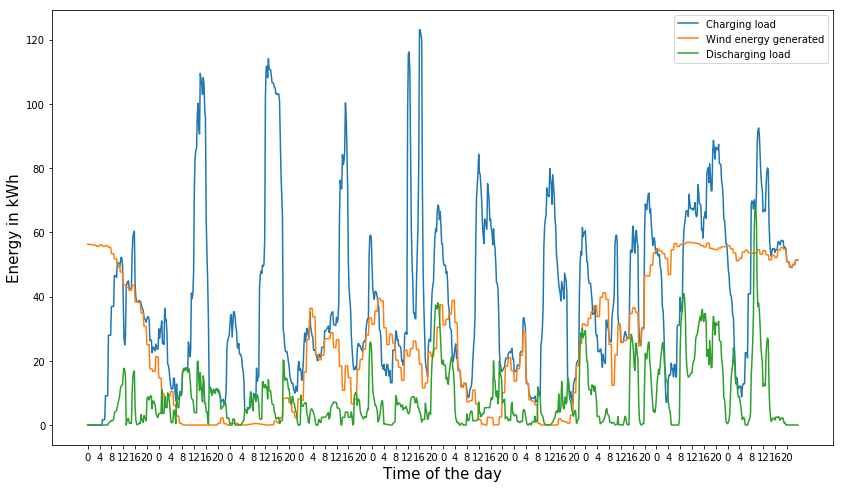

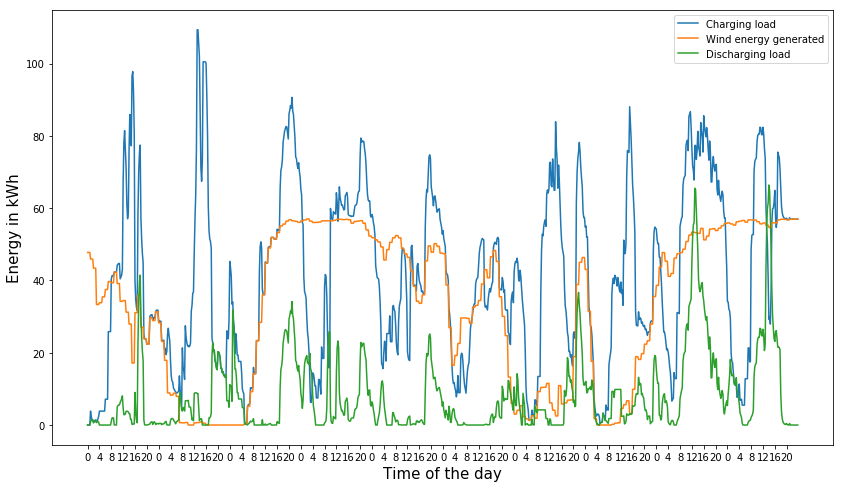

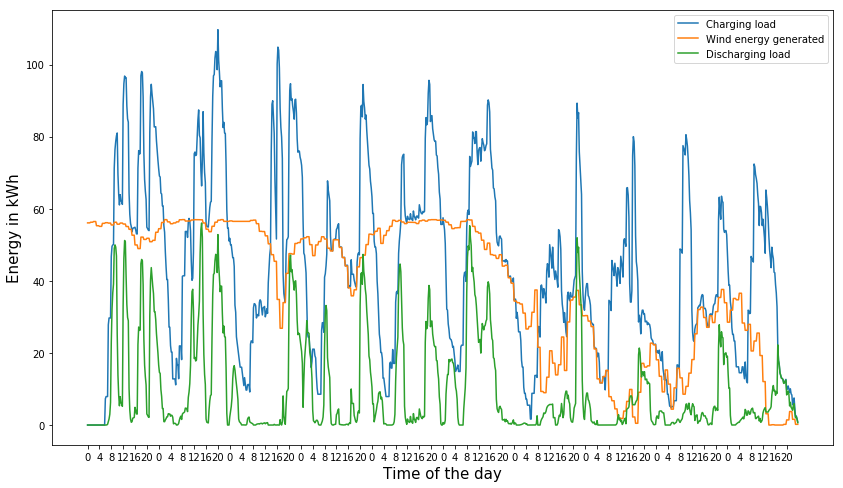

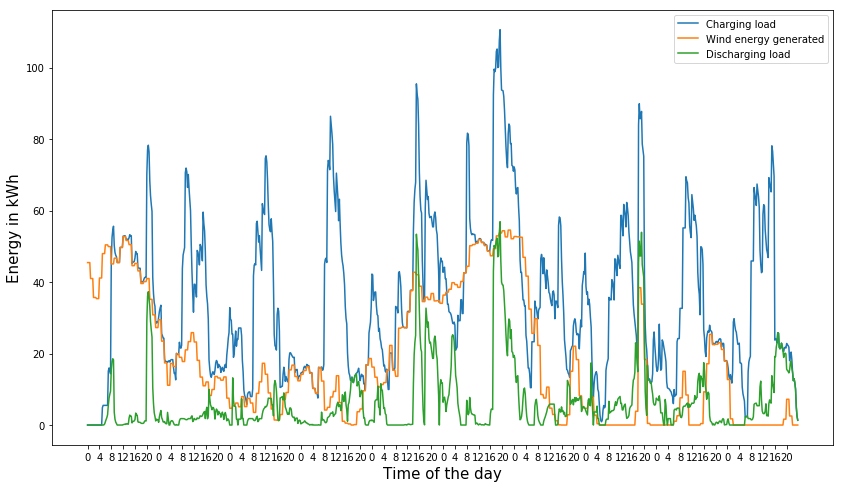

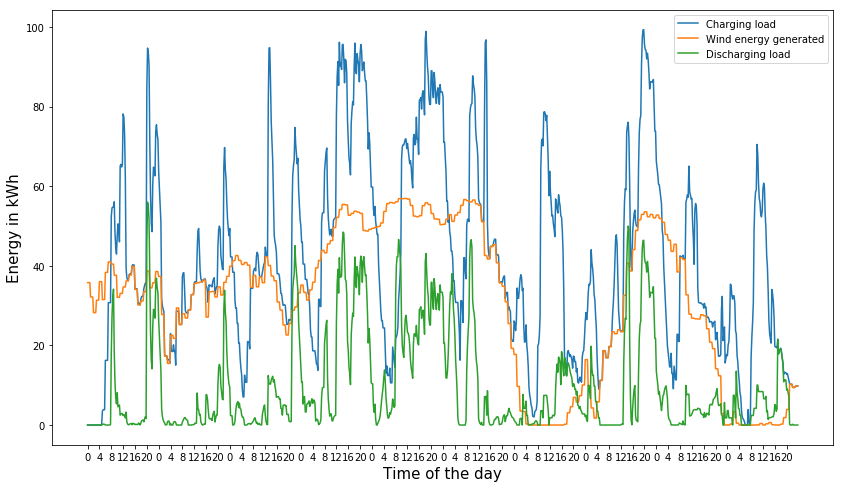

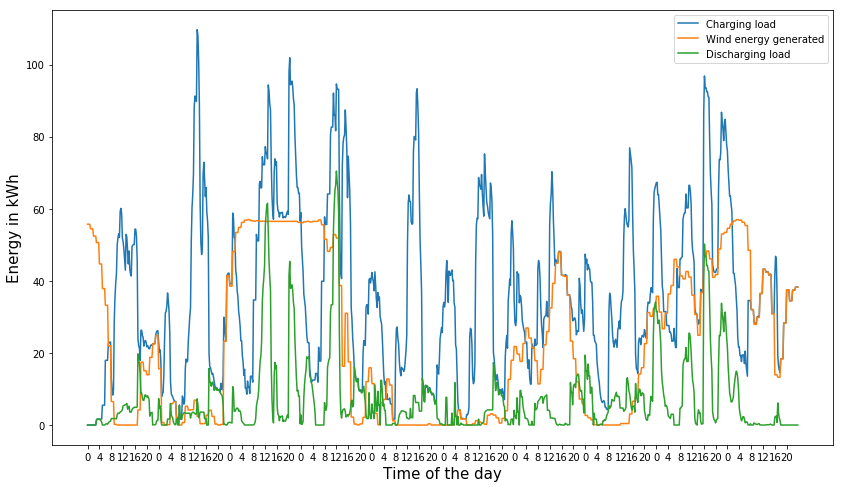

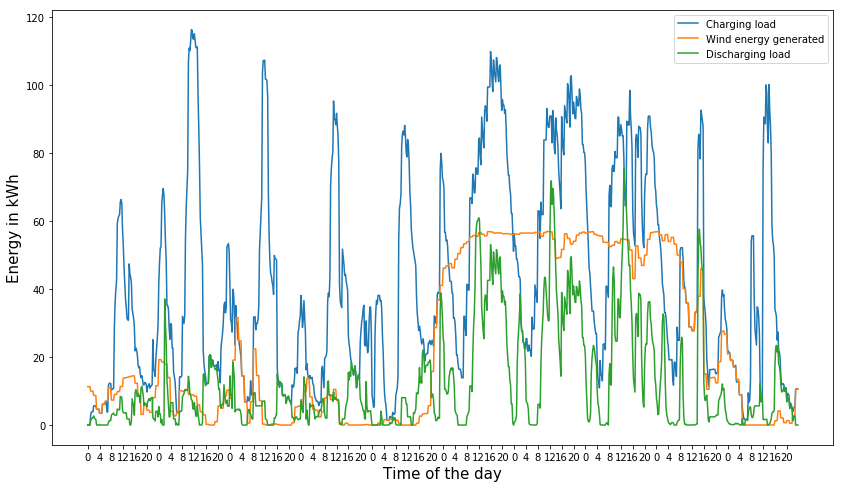

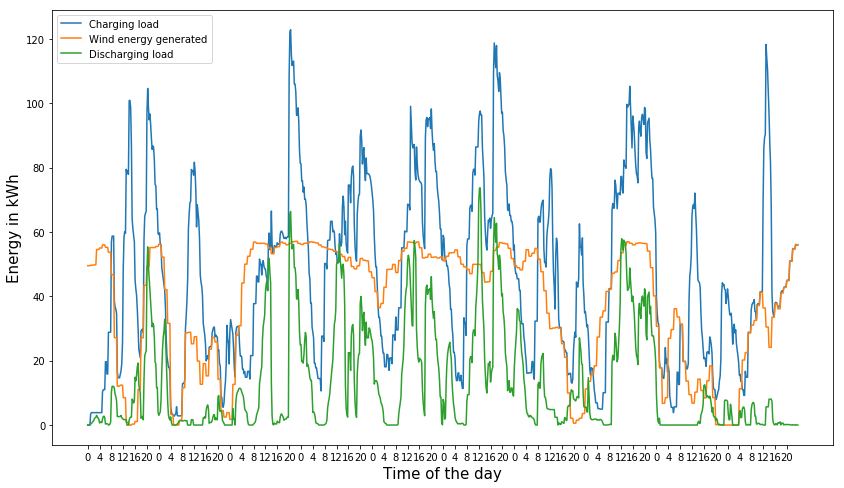

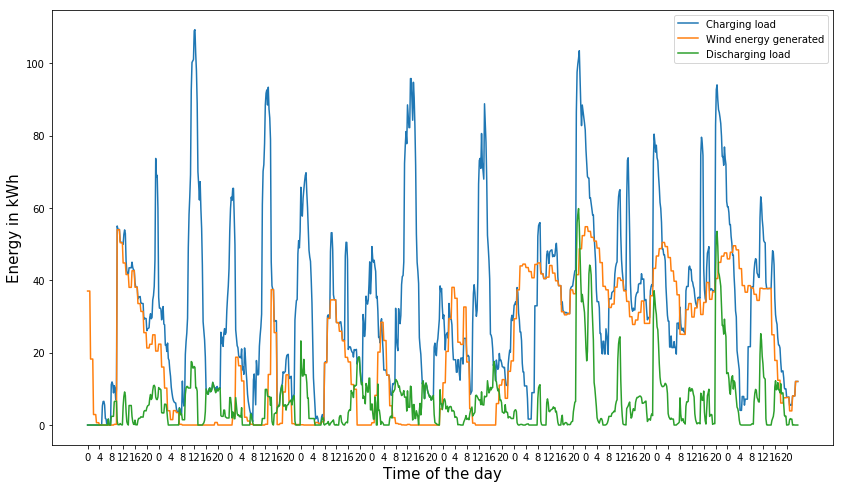

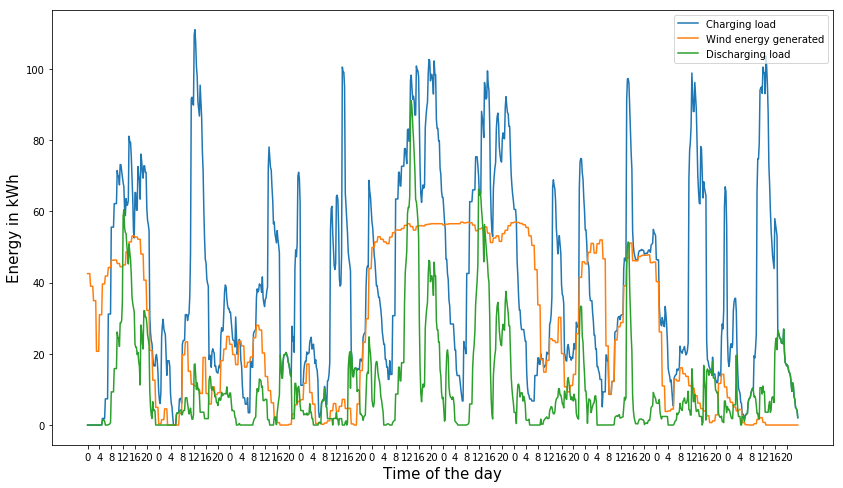

In [8]:
l=1
simulate_dynamic(S=10,low_Td=4, max_Td=12, eta_v=0.9, delta=1, delta1=1, delta2=0, delta3=1, NumberOfDays=10, eta_DC_v=0.9,
                        Day_of_Month=15, Trans_P = 100, timelim =1000)

In [25]:
df= pd.read_excel('EV_Dataset_Dynamic.xlsx')
df.head()

,Unnamed: 0,index,BC,AR,pc,chargepow,IS,DL,Ta,Td,...,Charge load kWh,Total Discharge kWh,Charge Cost,Wind Usage,Consumption from discharge,Consumption from grid,Degradation Cost,wind during park,Revenue,Is in V2G
0,0,1,32.000000,7.7,7.0,7.0,8.240458,26.204270,239,279,...,23.759542,5.79573,2.727741e+01,0.000000,0.0,2.375954e+01,2.519620,124.870801,18.378931,True
1,1,2,33.500000,7.7,6.6,6.6,0.470941,27.807020,41,62,...,29.700000,0.00000,0.000000e+00,29.700000,0.0,0.000000e+00,2.722500,940.745000,0.000000,True
2,2,3,25.025727,9.6,9.6,9.6,13.261133,22.625727,265,274,...,9.364594,0.00000,9.641942e-14,9.364594,0.0,1.287859e-14,0.920166,72.625225,0.000000,True
3,3,4,40.000000,15.4,17.2,15.4,18.613135,32.931898,239,251,...,14.318763,0.00000,1.631140e+01,0.000000,0.0,1.431876e+01,1.601874,0.478331,0.000000,True
4,4,5,32.000000,7.7,7.0,7.0,9.215519,30.013898,234,251,...,20.798379,0.00000,2.472458e+01,0.000000,0.0,2.079838e+01,1.868062,1.576837,0.000000,True


In [26]:
len(df)

1500

In [15]:
0.9*df['Revenue'].sum()

2309.8347675640043

In [18]:
df['WindUsage'].sum()

27883.051374423925

In [19]:
sum([9093.7414412, 16608.193688, 25335.112999999998]) - sum([3080.3823842625084, 7121.632045090922, 12951.982716830611])

27883.050983015957